In [1]:
from sampling_experiments_v1._helper import *
from sampling_experiments_v1.fold_metrics import FoldMetrics
from sampling_experiments_v1.model_selection import *
from sampling_experiments_v1.model_selection import _preprocess
from sampling_experiments_v1.experiment_plotter import ExpPlotter
from modified_loopstructural.modified_foldframe import FoldFrame
from modified_loopstructural.extra_utils import *
from LoopStructural import GeologicalModel
from LoopStructural.modelling.features.fold import FoldEvent
from LoopStructural.visualisation import LavaVuModelViewer
# from custom_model_visualisation import LavaVuModelViewer
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation import RotationAnglePlotter
from LoopStructural.modelling.features.fold import FoldRotationAngle, SVariogram
from LoopStructural.modelling.features import StructuralFrame, GeologicalFeature
from LoopStructural.modelling.features.fold import fourier_series
from LoopStructural.utils.helper import create_surface, create_box, get_data_bounding_box, normal_vector_to_strike_and_dip, plunge_and_plunge_dir_to_vector
import os
import time
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
import ipywidgets as widgets
from ipywidgets import IntProgress

# I. Creation of a synthetic model

1. Define model bounding box

In [2]:
# define the naximum value of xyz model box boundaries
xmin = 0
ymin = 0
zmin = 0
xmax = 1000
ymax = 1000
zmax = 1000
bounding_box = np.array([[xmin, ymin, zmin],
               [xmax, ymax, zmax]])

2. Initialise a geological model 

In [3]:
# initiliase geological model by initialising GeologicalModel class
model = GeologicalModel(bounding_box[0, :], 
                        bounding_box[1, :])

3. Build a fold frame

In [4]:
# Create a dataset for s1 to build a fold frame 
dataset, xyz = create_fold_frame_dataset(model, strike=0, dip=90)
# add data to the initiliased geological model
model.data = dataset

/mnt/c/Users/rcha0044/LoopPhD/repositories/14/synthetic_modelling/sampling_experiments_v1/_helper.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(s2y)


In [5]:
# build the s1 fold frame
s1 = model.create_and_add_fold_frame('s1',
                                          buffer=0.3,
                                          solver='pyamg',
                                          nelements=2e4,
                                        damp=True)
model.update()

  0%|          | 0/3 [00:00<?, ?it/s]


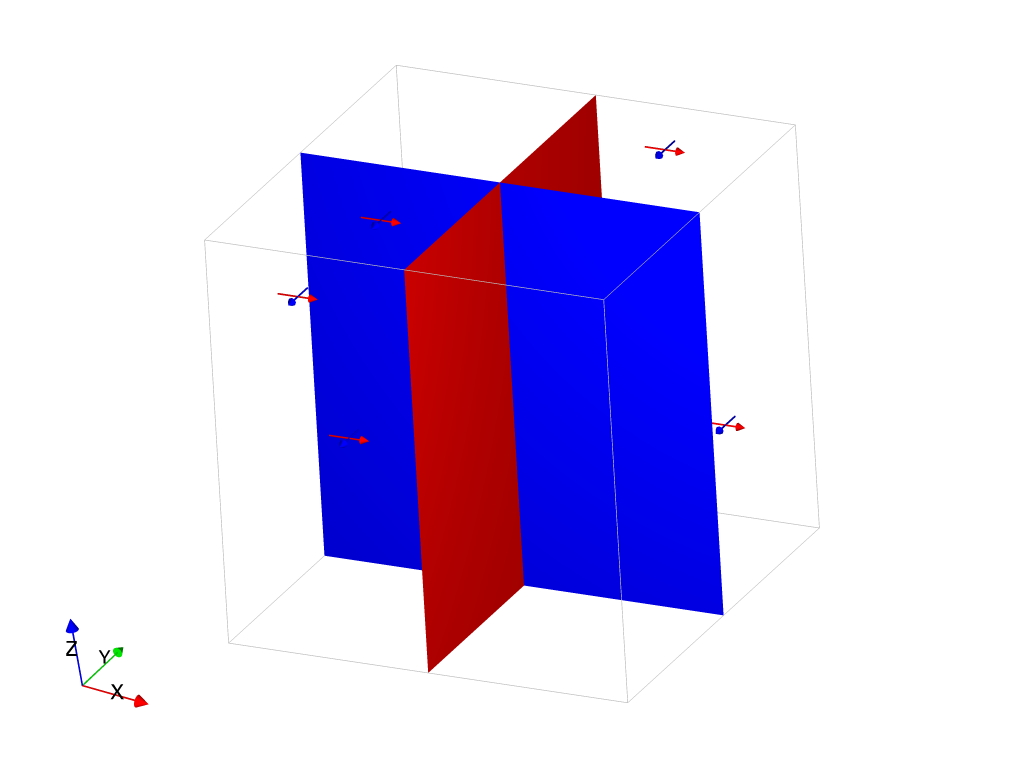

In [6]:
# 3D displaying the s1 fold frame
# import lavavu
viewer = LavaVuModelViewer(model, background='white')
viewer.add_isosurface(s1[0], colour='red')
viewer.add_isosurface(s1[1], colour='blue')
viewer.add_data(s1[0], disks=False, vectors=True, colour='red')
viewer.add_data(s1[1], disks=False, vectors=True, colour='blue')
# t = viewer.add_scalar_field(s1[0], cmap='prism')
# viewer.lv.colourbar(t, align=("bottom"))
viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
viewer.display()
viewer.interactive()

4. Define the fold limb rotation angle profile

In [7]:
def fold_limb_rotation_profile(c0, c1, c2, wl):

    theta = [c0, c1, c2, wl]
    x = np.linspace(s1[0].min(), s1[0].max(), 100)
    flr = np.rad2deg(np.arctan(fourier_series(x, *theta)))
    fold_limb_rotation = FoldRotationAngle(flr, x) 
    fold_limb_rotation.fitted_params = theta
    fold_limb_rotation.set_function(lambda x: np.rad2deg(
                    np.arctan(fourier_series(x, *theta))))
    plt.ylim(-90, 90)
    plt.xlabel('Fold Axial Surface Field')
    plt.ylabel('Fold Limb Rotation Angle')
    plt.title('Fold Limb S-Plot')
    plt.plot(x, flr)
    plt.show()
    
    return fold_limb_rotation

def define_fold_axis_orientation(plunge_direction, plunge): 
    
    fold_axis = plunge_and_plunge_dir_to_vector(plunge, plunge_direction)
    
    return fold_axis

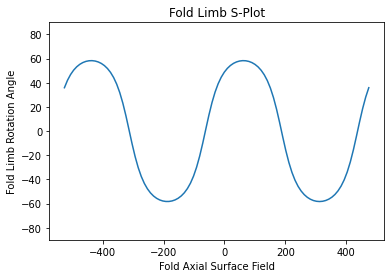

In [16]:
theta = [0, 2e-2, 2e-2, 500]
fold_limb_rotation = fold_limb_rotation_profile(*theta)

5. Calculate the normal vectors to the folded foliation

In [9]:
plunge_direction = 0
plunge = 0
fold_axis = define_fold_axis_orientation(plunge_direction, plunge)
fold = FoldEvent(s1, fold_limb_rotation=fold_limb_rotation)
fold.fold_axis = fold_axis 
fold_direction, fold_axis, dgz = fold.get_deformed_orientation(xyz)
dgx = s1[0].evaluate_gradient(xyz)
dgx /= np.linalg.norm(dgx, axis=1)[:, None]
# make sure fold direction vectors are normalised
fold_direction /= np.linalg.norm(fold_direction, axis=1)[:, None]
# calculate the dot product of the s1 and the fold direction
dot = np.einsum('ij,ij->i', dgx, fold_direction)
# correct the orientation of the fold direction vectors to be consistent
# with the direction of the axial surface 
fold_direction[dot<0] *= -1
# calculate the normal vectors of the folded foliation 
# which are the cross product of the fold axis and 
# the fold direction vectors
s0n = np.cross(fold_axis, fold_direction)
# normalise s0 normal vectors
s0n /= np.linalg.norm(s0n, axis=1)[:, None]

6. Create a dataset for s0

In [10]:
step = 4
dataset = pd.DataFrame()
s0_dict = create_gradient_dict(x=xyz[xyz[:, 2] == 0][:, 0][::step],
                               y=xyz[xyz[:, 2] == 0][:, 1][::step],
                               z=xyz[xyz[:, 2] == 0][:, 2][::step], 
                               nx=s0n[xyz[:, 2] == 0][:, 0][::step], 
                               ny=s0n[xyz[:, 2] == 0][:, 1][::step], 
                               nz=s0n[xyz[:, 2] == 0][:, 2][::step], 
                               feature_name='s0', coord=0, data_type='foliation')
dataset = dataset.append(pd.DataFrame(s0_dict, 
                                      columns
                                      =['X', 'Y', 'Z', 'gx', 'gy', 'gz', 'feature_name', 'coord']))

/tmp/ipykernel_1192/4221777650.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append(pd.DataFrame(s0_dict,


7. Build a 3D model of s0

In [11]:
fold_function = fold_limb_rotation.fold_rotation_function
model.data = dataset
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=s1,
                                            # limb_wl=500,
                                            av_fold_axis=True,
                                            limb_function=fold_function,
                                            nelements=9e5,
                                            solver='pyamg',
                                            buffer=0.3,
                                            damp=True)
model.update()
s0.fold.fold_limb_rotation.fitted_params = theta

  0%|          | 0/4 [00:00<?, ?it/s]

- Check the fold limb rotation angle if it is correct

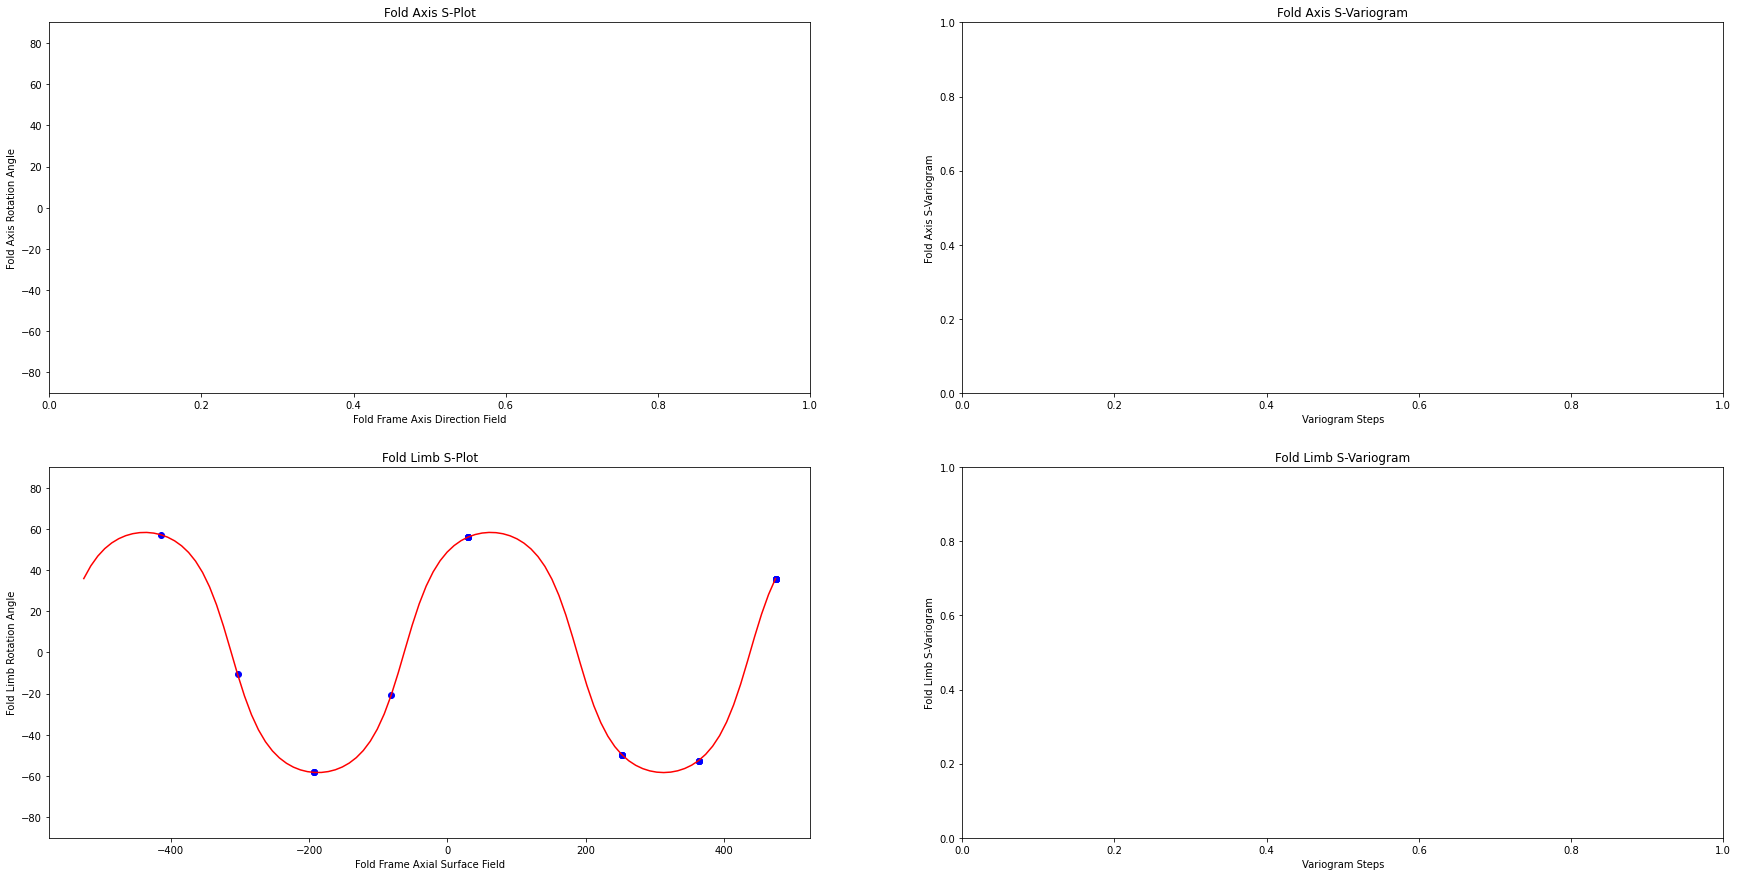

In [12]:
s0.set_model(model)
plotter = RotationAnglePlotter(s0)
plotter.default_titles()
plotter.add_fold_limb_data()
plotter.add_fold_limb_curve()
# plotter.add_limb_svariogram()
plt.show()

- Visualise the 3D model of s0


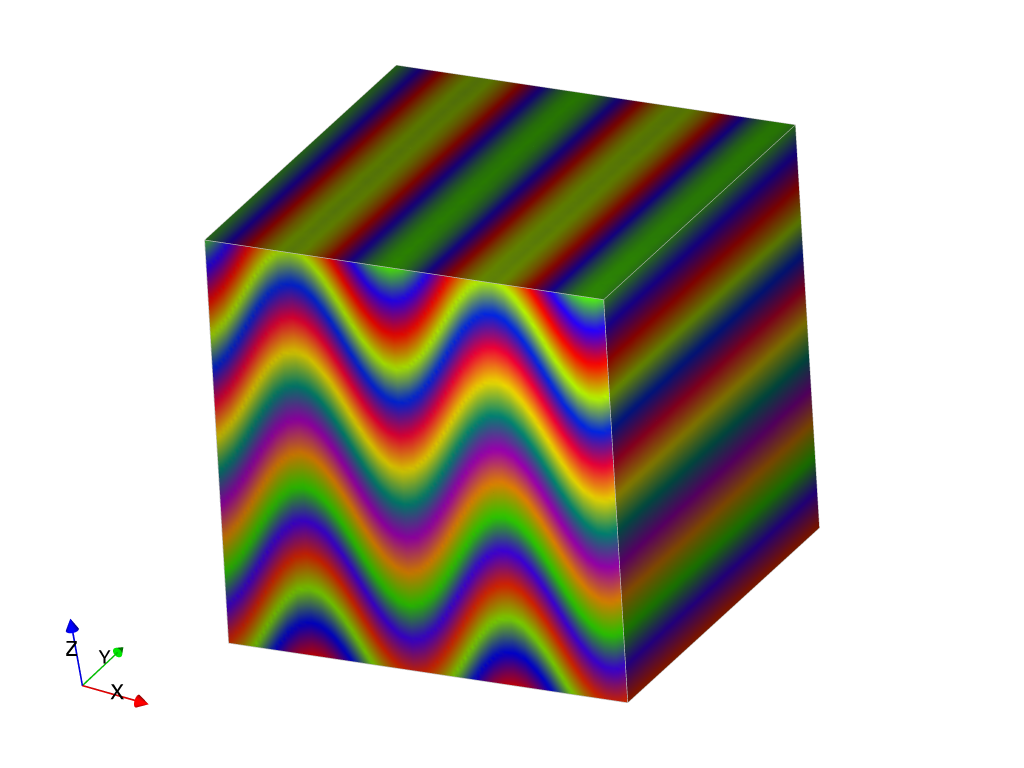

In [13]:
viewer = LavaVuModelViewer(model, background='white')
viewer.nsteps = np.array([100, 100, 100])
t = viewer.add_scalar_field(s0, cmap='prism')
# viewer.lv.colourbar(t, align=("bottom"))
viewer.lv.rotate([-63.015506744384766, -24.475210189819336, -8.501092910766602])
viewer.display()
viewer.interactive()

# II. Sampling experiments 

1. Generate a dense grid to sample

In [14]:
s1.model = model
xyz = model.regular_grid(nsteps=[100, 100, 100])
xyz0 = xyz[xyz[:, 2] == 0]
x = np.linspace(s1[0].min(), s1[0].max(), 100)

2. Calculate fold geodiversity metrics from the reference model

In [18]:
fold_metrics = FoldMetrics(s0, s0.model.bounding_box) 
ref_metrics = fold_metrics.all_metrics()

3. Run the experiments

In [19]:
# we choose the sample size starting from 2 data points 
# and we randomly sample 1000 dataset
sample_size = 4
locations, indices = sample_random_datasets(xyz, samples=1000, sample_size=sample_size, seed=180)
# get the orientation of the fold axis at each location
fold_axis  = np.mean(s0.fold.get_fold_axis_orientation(xyz), axis=0)
# create a dataset for the fold axis that has 
# the same shape as the locations array
fai = np.tile(fold_axis,  (len(locations[0]),1))
# initialise the fold frame class 
foldframe = FoldFrame('s0', model.features[0])
# initialise the arrays that will store the resutls of the experiments
curve = np.zeros((len(locations), 100))
fld = np.zeros((len(locations), len(locations[0])))
flr = np.zeros((len(locations), len(locations[0])))
recovery = np.zeros(len(locations))
_misfit = np.zeros(len(locations))
similarity = np.zeros(len(locations))
fitted_params = np.zeros((len(locations), 4))
opt_results = []
full_opt = []
theta = np.zeros((len(locations), 4))
lags = []#np.zeros((len(locations), 60))
variogram = []#np.zeros((len(locations), 60))
asymmetry = np.zeros(len(locations))
tightness = np.zeros(len(locations))
strike = np.zeros(len(locations))
dip = np.zeros(len(locations))
strike_2 = np.zeros(len(locations))
dip_2 = np.zeros(len(locations))
nvectors = np.zeros((len(locations), 3))
loc_grad = np.zeros((len(locations), sample_size, 6))
success = np.zeros(len(locations))


progress_bar = widgets.IntProgress(
        value=0,
        min=0,
        max=len(locations),
        description='Run No.:',
        bar_style='',  # 'success', 'info', 'warning', 'danger' or ''
        style={'bar_color': 'darkblue'},
        orientation='horizontal'
    )
# progress_bar.value = 0
display(progress_bar)
    
for i in range(len(locations)):

    progress_bar.value = i+1
    
    s0gg = s0.evaluate_gradient(locations[i])
    s0gg /= np.linalg.norm(s0gg, axis=1)[:, None]
    
    loc_grad[i] = np.array([locations[i][:, 0], 
                            locations[i][:, 1], 
                            locations[i][:, 2], 
                            s0gg[:, 0], 
                            s0gg[:, 1], 
                            s0gg[:, 2],]).T  
    
    flr[i], fld[i] = foldframe.calculate_fold_limb_rotation(locations[i], s0gg, 
                                                            axis=fai)
    if sample_size < 5: 
            
        pdist = np.abs(fld[i][:, None] - fld[i][None, :])
        pdist[pdist == 0.] = np.nan
        lagx = np.nanmean(np.nanmin(pdist, axis=1))
        theta[i], lag, vario = calculate_semivariogram(fld[i], flr[i], lag=lagx, nlag=60)
    else:
        theta[i], lag, vario = calculate_semivariogram(fld[i], flr[i], lag=None, nlag=None)
    variogram.append(vario)
    lags.append(lag)
    opt= least_squares(g, theta[i], args=[fld[i], flr[i]], 
                        method='trf', loss='soft_l1')

    fitted_params[i] = opt.x
    if opt.success == True:
        success[i] = 1
    if opt.success == False:
        success[i] = 0
    opt_results.append(opt)
    curve[i] = calculate_splot(x, fitted_params[i]) 
    _misfit[i] = np.sum(misfit(flr[i], fitted_params[i], fld[i]))
    curve[curve == 0] = np.nan
    # Calculate asymmetry index using the method of Grose et al. (2019)
    amin = np.abs(curve[i].min())
    amax = np.abs(curve[i].max())
    median = np.median(curve[i])
    limb_rotation_angle_range = amax + amin
    # calculate the asymmetry
    # the value of the asymmetry index could be positive or negative
    # for S or Z shaped asymmetry folds, respectively
    asymmetry[i] = median / limb_rotation_angle_range
    amax = np.arctan(np.deg2rad(curve[i].max()))
    amin = np.arctan(np.deg2rad(curve[i].min()))
    tightness[i] = 180 - np.rad2deg(2*np.tan((amax - amin) / 2))
success = success.astype(bool)
opt_results = np.asarray(opt_results)
wl = fitted_params[success, 3]
wl[wl == 0] = np.nan
twl = theta[success, 3]
wls = np.array([twl, wl], dtype=int).T
# variogram[variogram==0] = np.nan
# lags[lags == 0] = np.nan
recovery[recovery == 0] = np.nan
isnan = np.isnan(recovery)
lags = np.asarray(lags, dtype='object')[success]
variogram = np.asarray(variogram, dtype='object')[success]
metric = np.array([tightness[success], asymmetry[success],  wl]).T

IntProgress(value=0, description='Run No.:', max=1000, style=ProgressStyle(bar_color='darkblue'))

4. Compare and select models with good recovery and outliers

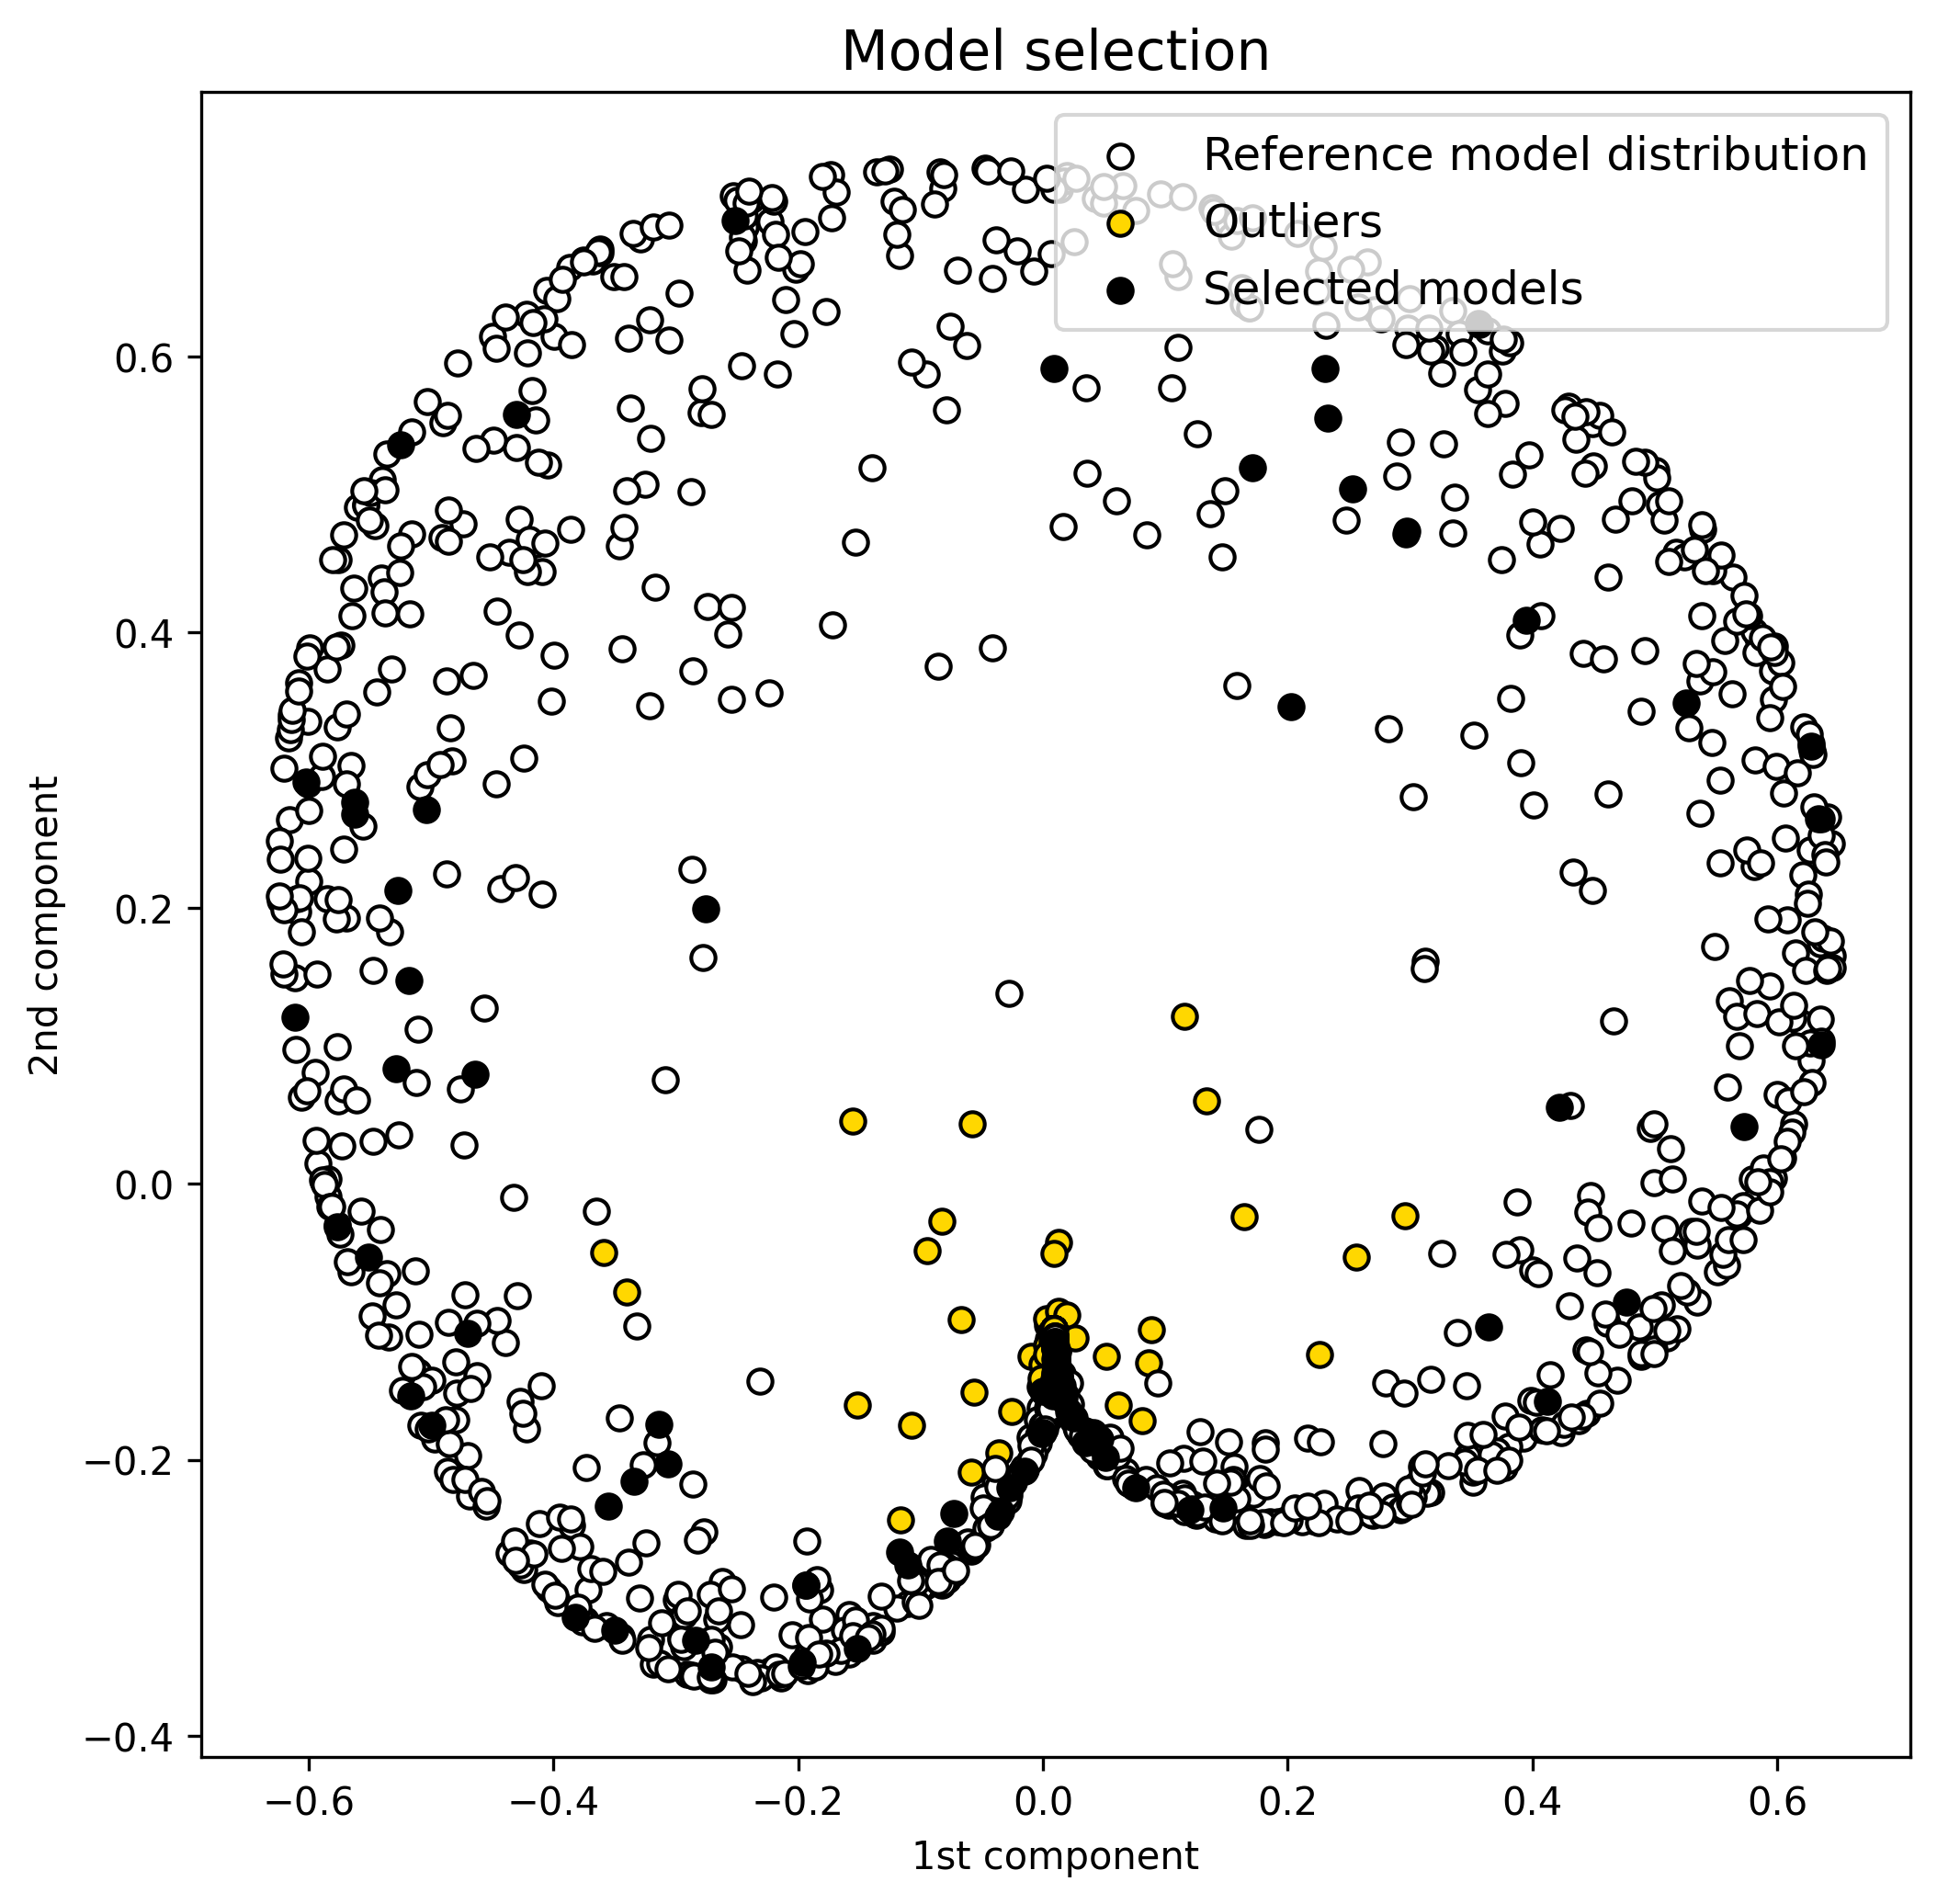

In [20]:
size = 1000
out_in, data, lof = detect_outliers(ref_metrics, metric,
                                       p=1, size=size, 
                                       preprocessing=None, reduce=None, 
                                       reduction_method='KPCA')
mask_oi = as_bool(out_in)
data_transformed = _preprocess(data[:size], data[size:], method=None)
reduced_data = reduce_dimensions_kpca(data_transformed, method='KPCA')
s = 40
plt.figure(figsize=(8, 8), dpi=300)
b1 = plt.scatter(reduced_data[:size, 0], reduced_data[:size, 1], 
                 c="white", s=s, edgecolors="k", zorder=2, 
                 label='Reference model distribution')
maskout = out_in[size:] == -1
c = plt.scatter(reduced_data[size:][~mask_oi, 0], 
                reduced_data[size:][~mask_oi, 1], 
                c="gold", s=s, edgecolors="k", 
                zorder=1, label='Outliers')
mask = out_in[size:] == 1
c1 = plt.scatter(reduced_data[size:][mask_oi, 0], 
                 reduced_data[size:][mask_oi, 1], 
                 c="black", s=s, edgecolors="k", zorder=3, 
                 label='Selected models')

plt.rcParams['font.size'] = 12
plt.title('Model selection')
plt.ylabel('2nd component')
plt.xlabel('1st component')
plt.legend(loc='upper right')
plt.show()

5. Visualising the results of the experiments

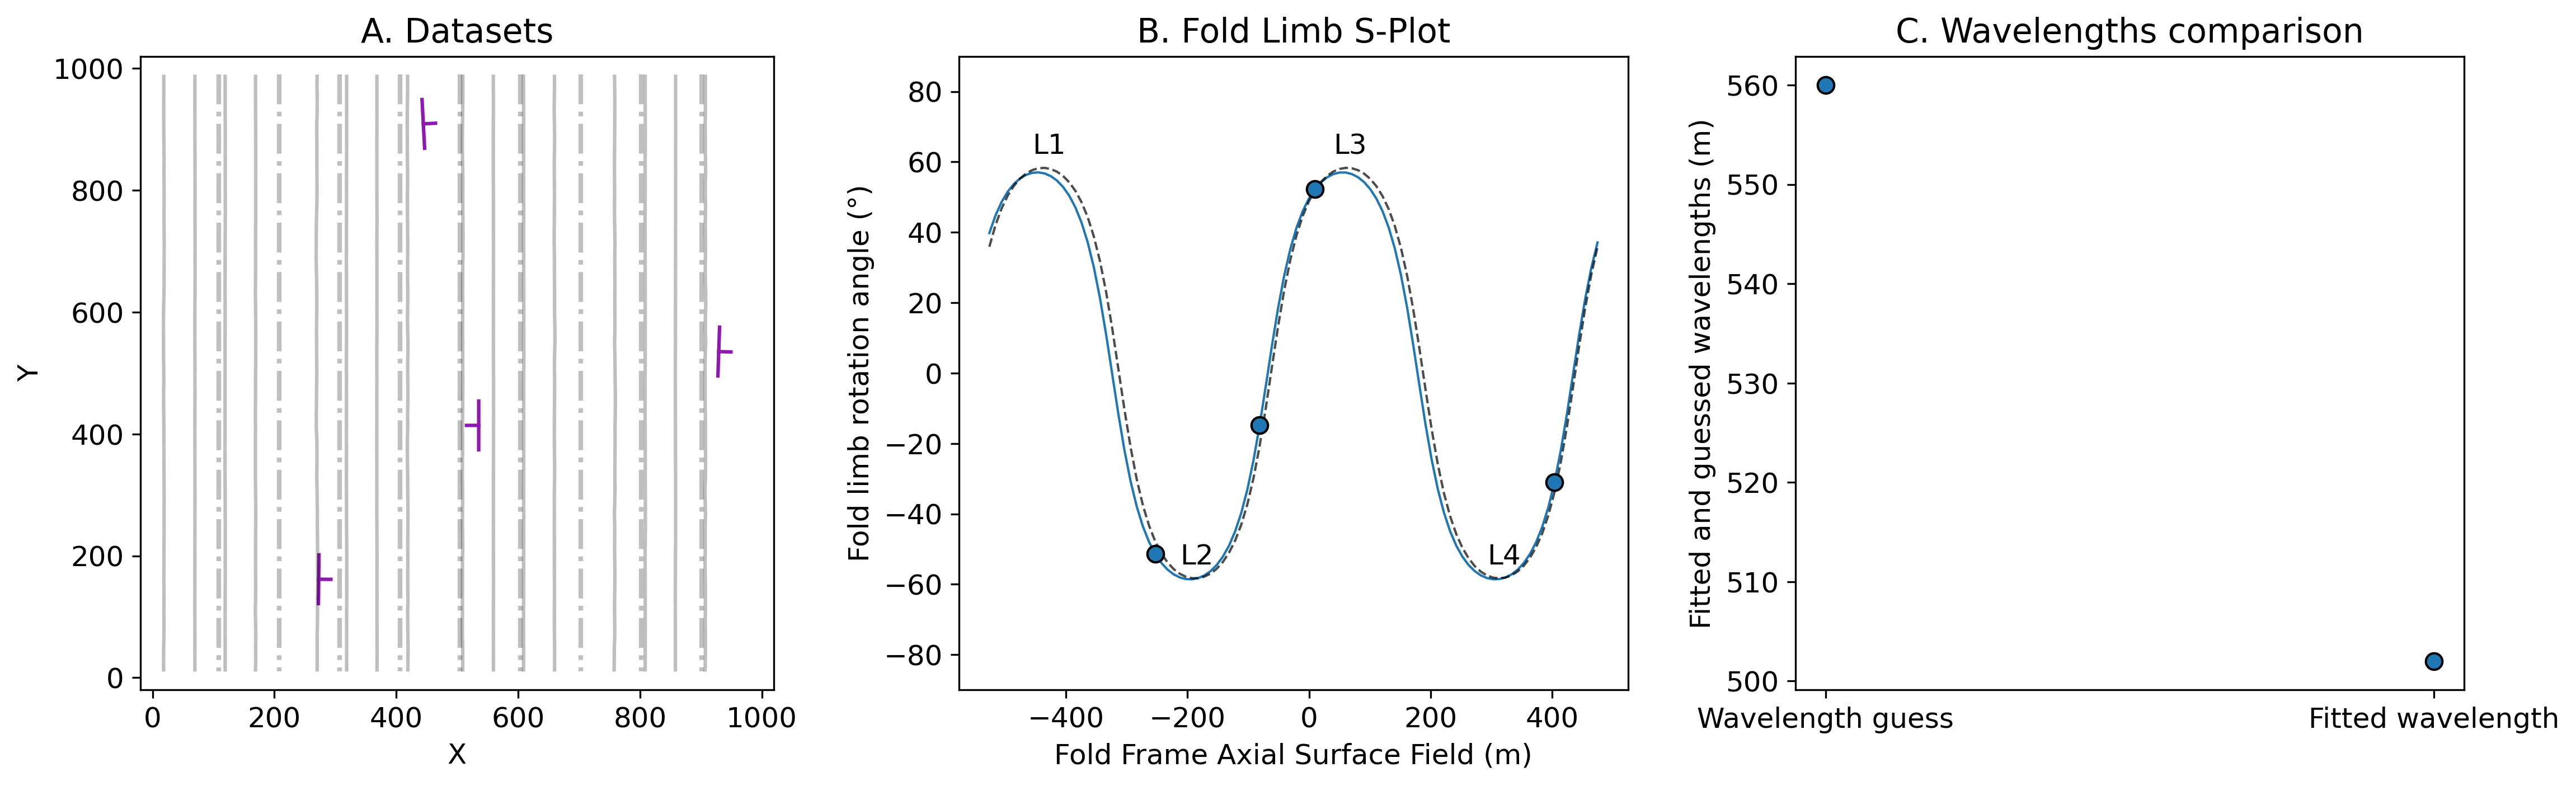

In [21]:
# mask_oi = as_bool(out_in) == False
ref_flr = s0.fold.fold_limb_rotation(x)
selection = select_randomly_models(fld[success][mask_oi], 
                                   sample_size=1, 
                                   seed=3)
# plots of fold axis 
exp_plotter = ExpPlotter(wspace=0.25, hspace=0.25, col=1, row=3, figsize=(18, 5))
# exp_plotter.fig, exp_plotter.ax = plt.subplots(1, 3, figsize=(10, 5)
# plot s-plot
plt.rcParams['lines.markersize'] = 500
exp_plotter.plot_multiple_arrays_xy(fld[success][mask_oi][selection], 
                                    flr[success][mask_oi][selection], 
                                    symbol='o', ix=1, zorder=len(flr)+200, 
                                    s=50, edgecolors="k", alpha=1)

exp_plotter.plot_multiple_arrays(x, 
                                 curve[success][mask_oi][selection], 
                                 zorder=len(flr)+100,
                                 ix=1, alpha=1, linewidth=1)

exp_plotter.plot(x, ref_flr, 1, symbol='--', color='black', 
                 alpha=0.7, zorder=len(flr)+100, linewidth=1)

exp_plotter.plot_wavelengths(wls[mask_oi][selection], 
                             symbol=None, 
                             ix=2, s=50, 
                             edgecolors="k")

exp_plotter.plot_dataset_map(loc_grad[success][mask_oi][selection], 
                             model.features, xyz, ix=0, scale=40,  
                             xmin=-20, xmax=1020, ymin=-20, ymax=1020,
                             inter=2000, axial_inter=1000)

# annotate the the limbs in the fold limb rotation angle profile
inflexion_points = np.asarray(find_peaks_and_troughs(x, ref_flr)).T
ss = inflexion_points[abs(inflexion_points[:, 1]) >= ref_flr.max()-1]
num = np.arange(1, len(ss)+1)
for i in range(len(num)):
    exp_plotter.ax[1].annotate('L'+str(num[i]), xy=ss[i], xytext=(ss[i, 0]-20, ss[i, 1]+4))
exp_plotter.fold_limb_titles()
exp_plotter.plot_limits()
plt.show()

6. Visualising the kernel density plot 

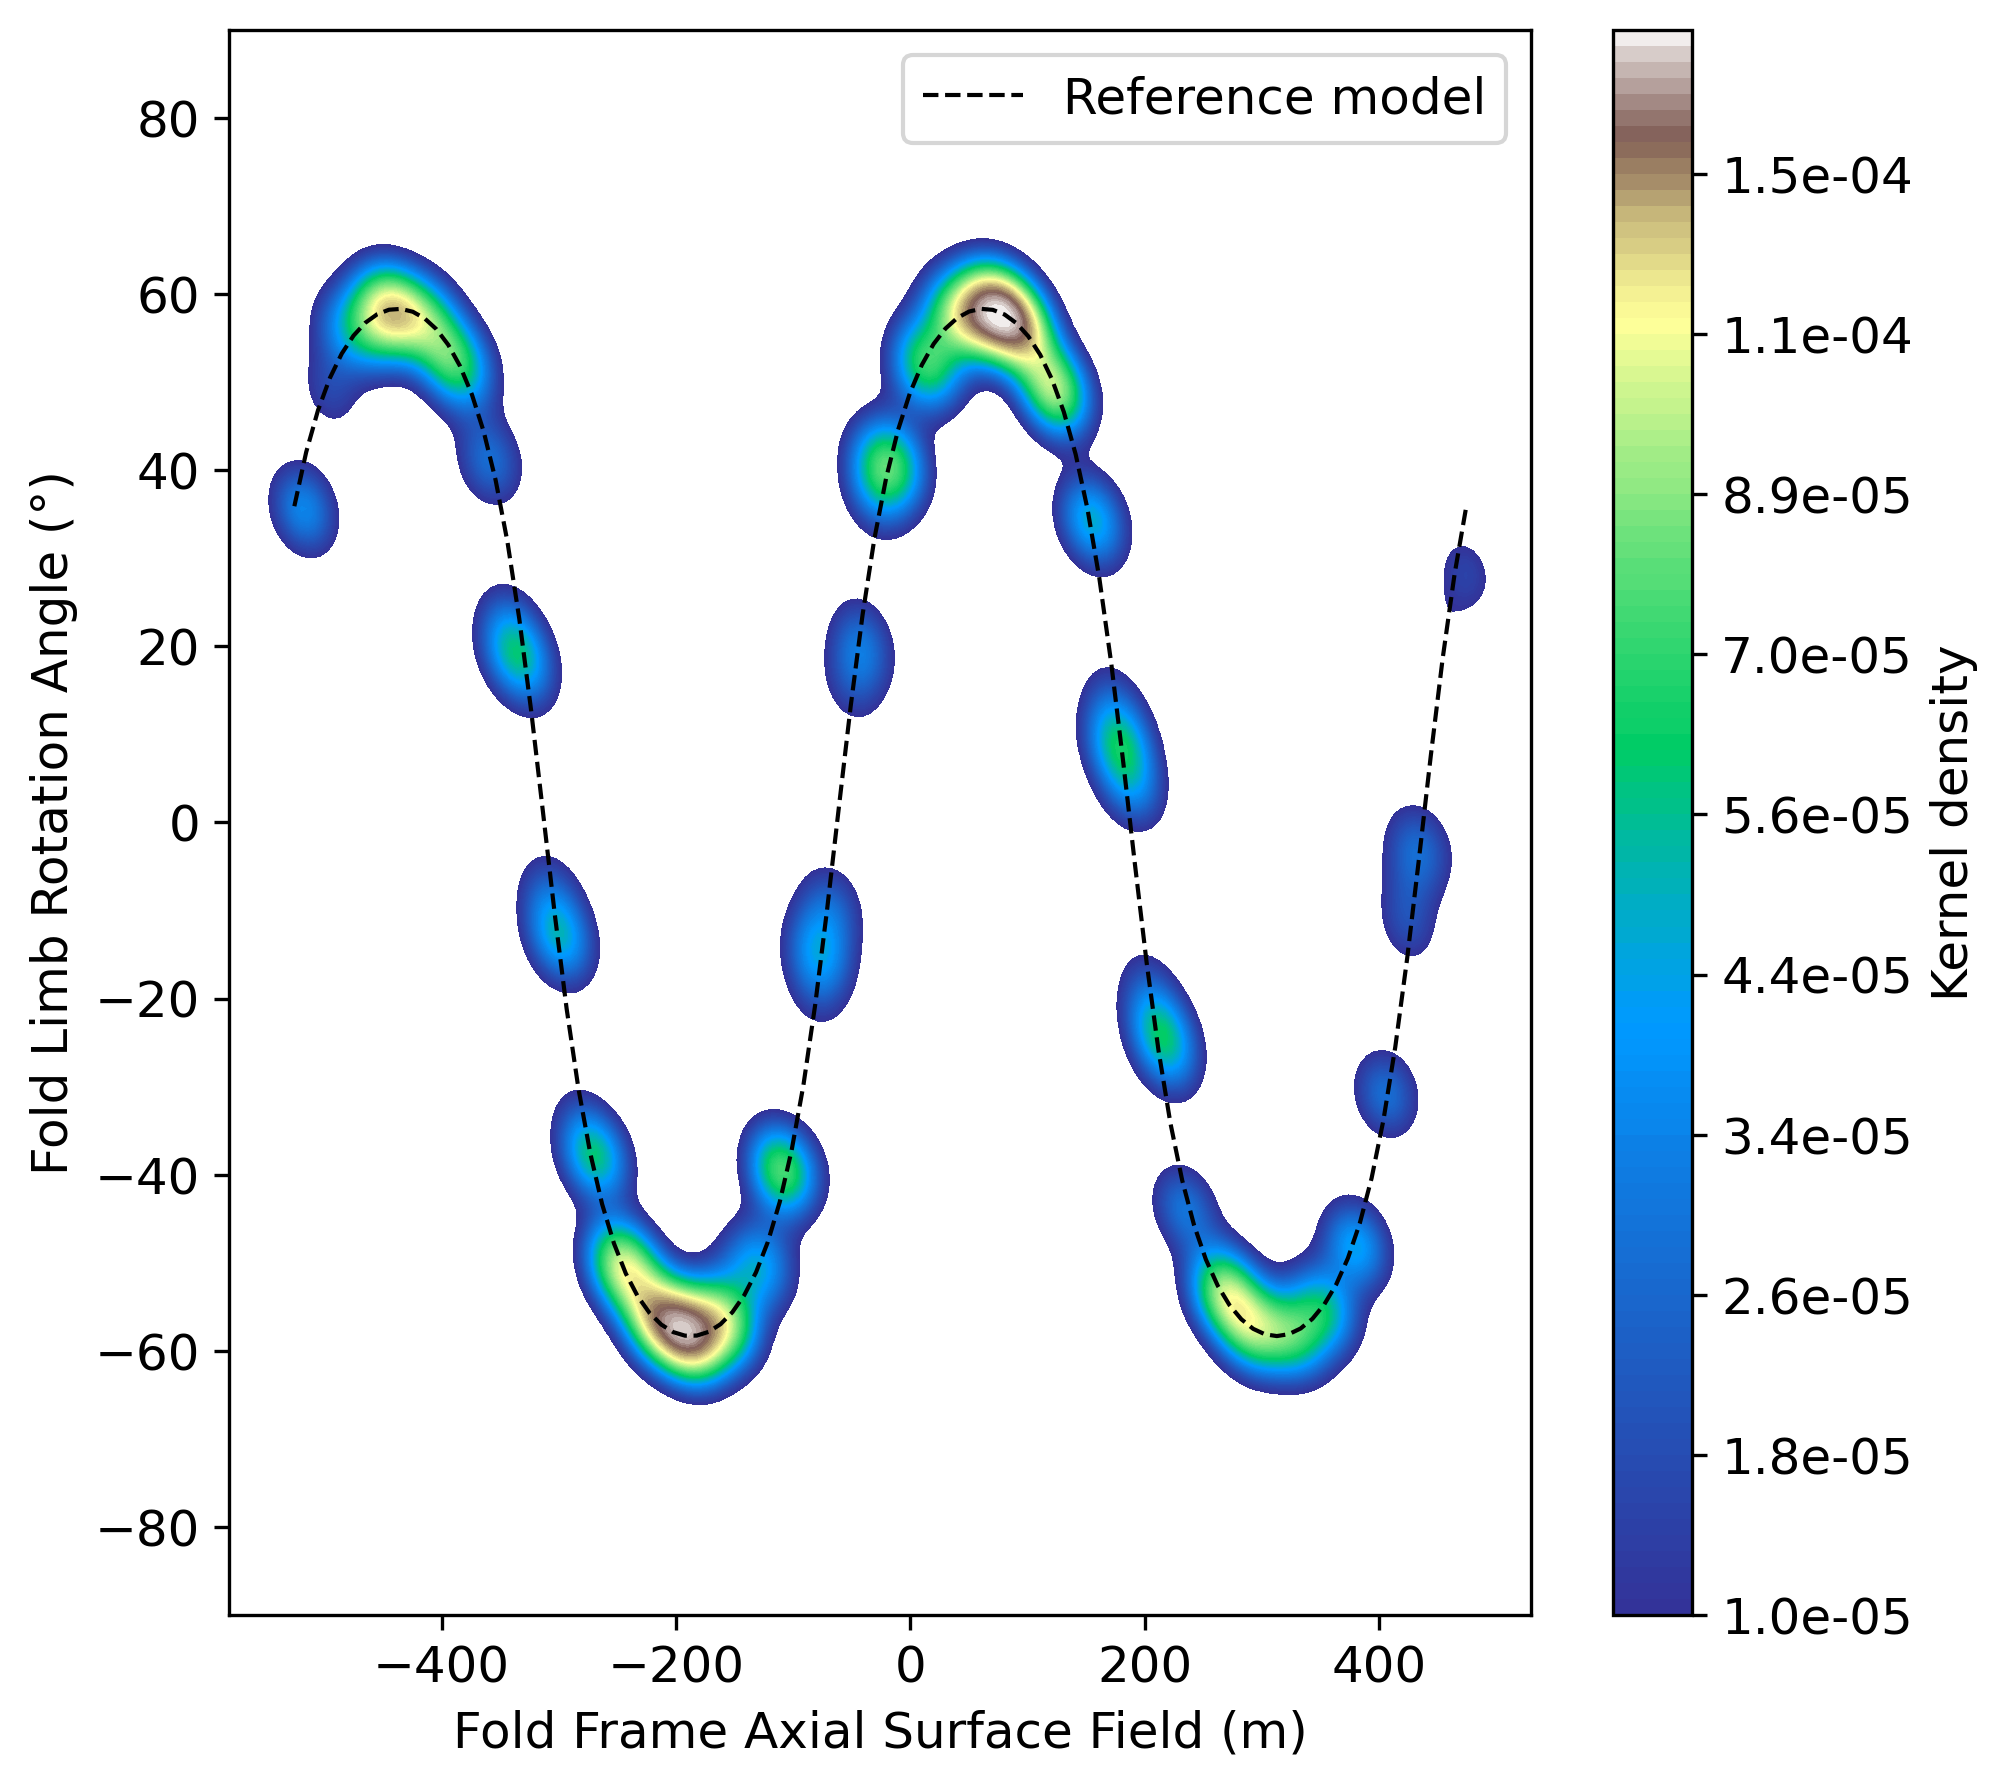

In [22]:
exp_plotter = ExpPlotter(wspace=0.25, hspace=0.25, col=1, row=1, figsize=(7, 7))
exp_plotter.splot_kernel_density(fld[success][mask_oi], 
                                 flr[success][mask_oi], 
                                 ax=exp_plotter.ax, b=0.4, tresh=0.1, cmap='terrain', 
                                 cbar_kws={'format': "%1.01e",
                                                                     'label':'Kernel density'})
exp_plotter.ax.plot(x, ref_flr,'--', color='black', 
                 alpha=1, zorder=len(flr)+100, linewidth=1, label='Reference model')
exp_plotter.ax.set_xlabel('Fold Frame Axial Surface Field (m)')
exp_plotter.ax.set_ylabel('Fold Limb Rotation Angle (°)')
exp_plotter.ax.set_ylim(-90, 90)
exp_plotter.ax.legend()




plt.show()